# OneStopEnglish: Data Cleaning and EDA
This script imports the One Stop English corpus, which consists of leveled text entries (beginner, intermediate, advanced) aligned to the same topic. Several features of the text entries are calculated using the `textstat` and `spacy` packages. These numerical features are then exported to a csv so they can be incoporated in a machine learning classification model that evaluates text complexity. Additional csv files are exported to finetune simpleGPT2 models for text generation. A list of the data prepared in this script is included below:
1. One column CSV files containing only text entries to be used to train NLP (simpleGPT2) models:
    1. _OSE\_adv\_int_: Matched advanced and intermediate texts, difficulty separated by indicator.
    1. _OSE\_adv\_ele_: Matched advanced and elementary texts, difficulty separated by indicator.
    1. _OSE\_int\_ele_: Matched intermediate adn elementary texts, difficulty separated by indicator.
1. A dataframe containing numerical characteristics about text entries to be used in training ML models to evaluate text complexity.
    1. _OSE\_TextFeat_

In [1]:
# Import packages
import numpy as np
import pandas as pd
import spacy
import nltk
import re
import textstat
import os
from os import listdir
from os.path import join, isfile
import chardet

In [2]:
# Function splits text, t, into sentences
def sent_break(t):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(t)
    return doc.sents

# Function counts the number of words in text t
def word_count(t):
    sents = sent_break(t)
    n_words = 0
    for s in sents:
        n_words += len([token for token in s])
    return n_words

# Function counts the number of sentences in text t
def sent_count(t):
    sents = sent_break(t)
    return len(list(sents))

In [3]:
# Sets option to display all text in pandas dataframes
pd.set_option('display.max_colwidth', None)

os.chdir("..")

# Get file path for OneStopEnglish Corpus from individual TXT files.
RawDat = os.getcwd() + '/data_raw/OneStopEng/TextByReadingLevel/'

# Set location to save clean data
ClnDat = os.getcwd() + '/data_clean/'

In [4]:
# For some reason there are two "Int" files--do not import the first, as it contains errors
SubDir = [join(RawDat, f)+'/' for f in listdir(RawDat) if f != 'Int-Txt']

# Load all texts into pandas data frame
TextDF = pd.DataFrame()

for s in SubDir:

    TextFiles = listdir(s)

    for t in TextFiles:
        # There is a hidden .ds_store file that should be skipped when importing data
        if t == '.DS_Store':
            pass
        else:
            with open(s + t, 'rb') as rawdat:
                result = chardet.detect(rawdat.read(10000))

                
            file = open(s + t, 'r', encoding = result['encoding'])
            text = file.read()
            file.close()

            # Append text data and file name to dataframe
            TextDF = TextDF.append({'file_nm' : t,
                                    'text' : text},
                                   ignore_index = True)

In [5]:
# Isolate name and level of text
TextDF['name'] = TextDF['file_nm'].str[:-8]
TextDF['level'] = TextDF['file_nm'].str[-7:-4]
TextDF['text'] = TextDF['text'].apply(str)

# TextDF.groupby(['level'])['text'].count()

# Intermediate text is labeled--this should be removed
# TextDF['text'] = TextDF['text'].map(lambda x: x.lstrip('Intermediate'))
# TextDF['text'] = TextDF['text'].str.replace('\n', ' ')

In [6]:
# Pivot text to level
TextDF_w = TextDF.pivot(index = ['name'], columns = ['level'], values = ['text']).reset_index()

# Flatten column index of pivot table
TextDF_w.columns = TextDF_w.columns.map('_'.join).str.strip('_')

# Match text pairs accross levels to train GPT2 Model
TextDF_w['adv_int'] = TextDF_w['text_adv'] + '\n |<endoflevelone>| \n' + TextDF_w['text_int']
TextDF_w['adv_ele'] = TextDF_w['text_adv'] + '\n |<endoflevelone>| \n' + TextDF_w['text_ele']
TextDF_w['int_ele'] = TextDF_w['text_int'] + '\n |<endoflevelone>| \n' + TextDF_w['text_ele']

# Export matched text columns to csv file to finetune SimpleGPT2, need to specify encoding or odd figures are saved
# One column must be included for file to successfully be read into SimpleGPT2
for lev in ['adv_int', 'adv_ele', 'int_ele']:
    TextDF_w[lev] = TextDF_w[lev].apply(str)
    TextDF_w[lev].to_csv(ClnDat+'OSE_'+lev+'.csv', encoding = 'utf-8-sig', index = False)

In [7]:
# Clean text (text_c) by lowering, removing numbers, removing symbols, and reducing to single space
TextDF['text_c'] = TextDF['text'].str.lower().str.replace(r'[^a-zA-Z\s]', '')
TextDF['text_c'] = TextDF['text_c'].str.replace(r'\n', ' ').str.replace(r'\s+\s', ' ')

In [8]:
# This step is separate from the other text statistic computations because it takes a longer time to run
# Compute text difficulty using textstat
TextDF['difficulty'] = TextDF['text'].apply(textstat.flesch_reading_ease)

# Compute sentence length
TextDF['n_sent'] = TextDF['text'].apply(sent_count)

In [16]:
# Compute additional text statistics
TextDF['n_syll'] = TextDF['text'].apply(textstat.syllable_count) # Number of syllables
TextDF['n_lex'] = TextDF['text'].apply(textstat.lexicon_count) # Number of words
TextDF['lex_sent'] = TextDF['n_lex']/TextDF['n_sent'] # Word to sentence ratio
TextDF['syll_lex'] = TextDF['n_syll']/TextDF['n_lex'] # Syllable to word ratio

# Save text statistc data to csv
TextDF.to_csv(ClnDat+'OSE_TextFeat.csv', encoding = 'utf-8-sig', index = False)

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: n_sent, dtype: object

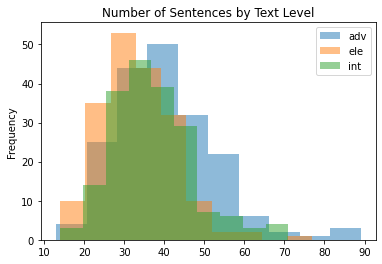

In [10]:
TextDF.groupby('level')['n_sent'].plot(kind = 'hist', legend = True, alpha = 0.5, 
                                       title = 'Number of Sentences by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: n_syll, dtype: object

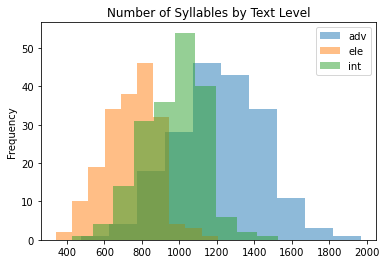

In [11]:
TextDF.groupby('level')['n_syll'].plot(kind = 'hist', legend = True, alpha = 0.5, 
                                       title = 'Number of Syllables by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: n_lex, dtype: object

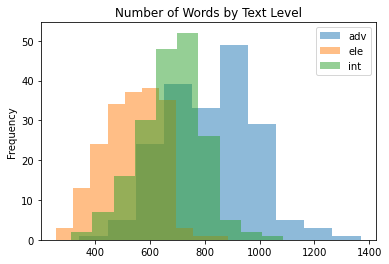

In [12]:
TextDF.groupby('level')['n_lex'].plot(kind = 'hist', legend = True, alpha = 0.5,
                                      title = 'Number of Words by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: lex_sent, dtype: object

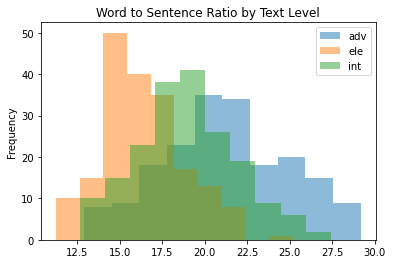

In [13]:
TextDF.groupby('level')['lex_sent'].plot(kind = 'hist', legend = True, alpha = 0.5,
                                         title = 'Word to Sentence Ratio by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: syll_lex, dtype: object

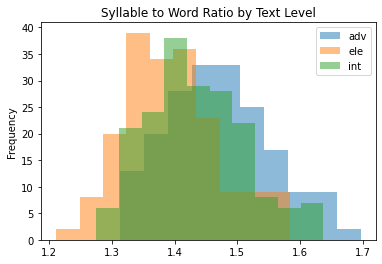

In [14]:
TextDF.groupby('level')['syll_lex'].plot(kind = 'hist', legend = True, alpha = 0.5, 
                                         title = 'Syllable to Word Ratio by Text Level')

level
adv    AxesSubplot(0.125,0.125;0.775x0.755)
ele    AxesSubplot(0.125,0.125;0.775x0.755)
int    AxesSubplot(0.125,0.125;0.775x0.755)
Name: difficulty, dtype: object

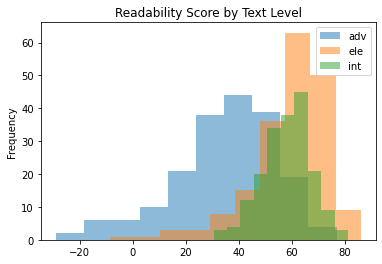

In [15]:
TextDF.groupby('level')['difficulty'].plot(kind = 'hist', legend = True, alpha = 0.5, 
                                           title = 'Readability Score by Text Level')

In [ ]:
###################################
# IMPORT DATA STORED IN CSV FILES #
###################################

# Get file path to OneStopEnglish Corpus including combined CSV files.
FilePath = os.getcwd() + '/OneStopEng/TextOneCSVPerFile/'

# Texts are organized by difficulty level
Files = listdir(FilePath)

# Import all texts into pandas dataframe
oseDF = pd.DataFrame() # Initialize dataframe

# Loop through all files
for f in Files:
    
    # Files have different encodings
    # Find the encoding for each file and use that in read_csv command
    with open(FilePath + f, 'rb') as rawdat:
        result = chardet.detect(rawdat.read(10000))
        
    oseDFA = pd.read_csv(FilePath + f, encoding = result['encoding'])
    oseDFA['name'] = f
    
    oseDF = oseDF.append(oseDFA)